# Аналитика данных компании Gectaro

**Цель проекта**  
  
Проанализировать имеющиеся данные, составить портреты наиболее типичных клиентов, разобраться в причинах оттока клиентов, предложить решения по их минимизации. Для этого предлагается определить ключевые признаки для компаний, наличие которых (или их появление) влияет на отмену (отсутствие оплаты) подписки.

## Загрузка данных и подготовка к анализу

### Загрузка библиотек

In [1]:
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import warnings

Уберем ограничение по выводу строк, колонок и символов в записи и включаем игнорирование ошибок Jupiter.

In [2]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

#Игнорируем предупреждения Jupiter
warnings.filterwarnings('ignore')

Прописываем темы визуализации.

In [3]:
sns.set_style('darkgrid')
plt.style.use('ggplot')

### Загрузка данных

Запишем датафрейммы  activities.csv, billing.csv, companies.csv и people.csv в датасеты  activities, billing, companies и people соответственно.

In [4]:
try:
    activities, billing, companies, people = (
        pd.read_csv('data/activities.csv', index_col=0),
        pd.read_csv('data/billing.csv', index_col=0),
        pd.read_csv('data/companies.csv', index_col=0),
        pd.read_csv('data/people.csv', index_col=0)
    )


except:
    activities, billing, companies, people = (
        pd.read_csv('activities.csv', index_col=0),
        pd.read_csv('billing.csv', index_col=0),
        pd.read_csv('companies.csv', index_col=0),
        pd.read_csv('people.csv', index_col=0)
    )

Подготовим функцию для вывода информации о датафрейме.

In [5]:
def get_info(df):
    """
    Функция для вывода информации о датафрейме
    
    Args:
        df: датафрейм 
        
    Returns:
        print(информация о датафрейме)
        display(первые 5 строк датафрейма).
    """

    print(df.info())
    display(df.head())

Посмотрим информацию о датафреймах.

In [6]:
get_info(activities)

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_id                     6316 non-null   int64  
 1   month                          6316 non-null   object 
 2   company-month-billing          6316 non-null   float64
 3   company-month-stocks           6316 non-null   float64
 4   company-month-backups          6316 non-null   float64
 5   company-month-projects         6316 non-null   float64
 6   company-month-contractors      6316 non-null   float64
 7   company-month-resource_orders  6316 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 444.1+ KB
None


,company_id,month,company-month-billing,company-month-stocks,company-month-backups,company-month-projects,company-month-contractors,company-month-resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


В нашем распоряжении **activities** датафрейм из 8 колонок и 6316 строк.
- `company_id` -  Идентификатор компании
- `month` -  Отчетный месяц
- `company-month-billing` -  Количество счетов, выставленных в приложении, компанией за месяц
- `company-month-stocks` -  Месячное количество складов (аренда, заказы и т.д.), используемых компанией
- `company-month-backups` -  Месячное количество бэкапов компании
- `company-month-projects` -  Месячное количество проектов компании
- `company-month-contractors` -  Месячное количество контрагентов компании
- `company-month-resource_orders` -  Месячное количество заказов материалов компании

In [7]:
get_info(billing)

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               3480 non-null   int64  
 1   id                       3480 non-null   int64  
 2   user_id                  3480 non-null   int64  
 3   company_id               3480 non-null   int64  
 4   billing_tariff_id        3480 non-null   int64  
 5   payed_until              3480 non-null   int64  
 6   is_payed                 3480 non-null   bool   
 7   created_at               3480 non-null   int64  
 8   updated_at               3480 non-null   int64  
 9   billing_tariff_price_id  3480 non-null   float64
 10  comment                  745 non-null    object 
 11  pay_date                 1108 non-null   float64
dtypes: bool(1), float64(2), int64(8), object(1)
memory usage: 329.6+ KB
None


,Unnamed: 0,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,4,3050,567,512,3,1640153302,False,1608617302,1608617302,12.0,NaN,NaN
6,6,3051,2861,2474,7,1640131200,True,1608626162,1608626181,23.0,NaN,1.608626e+09
16,16,3059,1902,1645,2,1616577484,False,1608801484,1608801484,6.0,NaN,NaN
18,18,3065,2352,2035,7,1643500799,False,1608883175,1608883175,23.0,NaN,NaN
24,24,3062,1074,926,3,1611964800,True,1608814072,1608899674,9.0,NaN,1.609200e+09


В нашем распоряжении **billing** датафрейм из 12 колонок и 3480 строк.
- `Unnamed:0` - Старый индекс
- `id` - Неизвестная колонка
- `user_id` - Идентификатор пользователя
- `company_id` - Идентификатор компании пользователя
- `billing_tariff_id` - Тарифный план
- `payed_until` - Дата, до которой подписка компании действует
- `is_payed` - Статус оплаты
- `created_at` - Дата создания
- `updated_at` - Дата обновления
- `billing_tariff_price_id` - id стоимости тарифа
- `comment` - Комментарии
- `pay_date` - Дата платежа

In [8]:
get_info(companies)

<class 'pandas.core.frame.DataFrame'>
Index: 723 entries, 19 to 17972
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       723 non-null    int64  
 1   working_direction        720 non-null    object 
 2   employer_count_interval  723 non-null    float64
 3   created_at               723 non-null    int64  
 4   updated_at               723 non-null    int64  
 5   billing_tariff_id        716 non-null    float64
 6   billing_is_over          723 non-null    bool   
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 40.2+ KB
None


,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
19,514,-,1.0,1571316635,1670298314,4.0,True
57,383,Строительство,2.0,1564142565,1676550050,7.0,False
69,495,-,1.0,1570535695,1598281714,2.0,False
75,724,-,1.0,1579514393,1670298294,4.0,True
99,471,-,1.0,1569328017,1670298360,7.0,True


В нашем распоряжении **companies** датафрейм из 7 колонок и 723 строк.
- `id` - id компании
- `working_direction` - сфера деятельности
- `employer_count_interval` - id количества сотрудников
- `created_at` - дата создания компании в системе
- `updated_at` - дата обновления информации о компании
- `billing_tariff_id` - id тарифа 
- `billing_is_over` - истекла ли оплата



In [9]:
get_info(people)

<class 'pandas.core.frame.DataFrame'>
Index: 5095 entries, 2 to 17054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5095 non-null   int64  
 1   company_id  5095 non-null   int64  
 2   user_id     3813 non-null   float64
 3   role_id     5095 non-null   int64  
 4   created_at  5095 non-null   int64  
 5   updated_at  5095 non-null   int64  
 6   is_deleted  5095 non-null   bool   
 7   deleted_at  2180 non-null   float64
dtypes: bool(1), float64(2), int64(5)
memory usage: 323.4 KB
None


,id,company_id,user_id,role_id,created_at,updated_at,is_deleted,deleted_at
2,6601,495,NaN,7133,1570535962,1570535962,True,1.594067e+09
6,7025,1,NaN,1,1594120484,1594120484,True,1.594120e+09
7,7165,1255,1734.0,18085,1595438102,1595439391,True,1.633960e+09
10,7130,1470,1703.0,1,1595234824,1595234824,False,NaN
17,7163,1492,1731.0,1,1595429211,1598540644,True,1.620195e+09


В нашем распоряжении **people** датафрейм из 8 колонок и 5095 строк.
 - `id`- индекс
 - `company_id`- id компании
 - `user_id`- id пользователя
 - `role_id`- id роли (должности)
 - `created_at`- дата создания пользователя
 - `updated_at`- дата обновления информации о пользователе
 - `is_deleted`- удален ли пользователь
 - `deleted_at`- дата удаления

Сохраним информацию о размерах датафреймов.

In [10]:
activities_start_shape = activities.shape
billing_start_shape = billing.shape
companies_start_shape = companies.shape
people_start_shape = people.shape

### Предобработка данных

#### Переименование столбцов

Приведем название столбцов в датафрейме **activities** к "змеиному регистру".

In [11]:
activities.columns = [re.sub('-', '_',  i) for i in activities.columns]
print(activities.columns)

Index(['company_id', 'month', 'company_month_billing', 'company_month_stocks',
       'company_month_backups', 'company_month_projects',
       'company_month_contractors', 'company_month_resource_orders'],
      dtype='object')


Переименование прошло успешно.

#### Удаление столбцов

Удалим столбец `Unnamed: 0` в датафрейме **billing**, т.к. он появился при формировании csv файла и содержит старые индексты.

In [12]:
billing = billing.drop(columns=['Unnamed: 0'])
print(billing.columns)

Index(['id', 'user_id', 'company_id', 'billing_tariff_id', 'payed_until',
       'is_payed', 'created_at', 'updated_at', 'billing_tariff_price_id',
       'comment', 'pay_date'],
      dtype='object')


Удаление прошло успешно.

#### Проверка на пропуски

Проверим датафреймы на пропуски.

In [13]:
activities.name = 'activities'
billing.name = 'billing'
companies.name = 'companies'
people.name = 'people'

for i in (activities, billing, companies, people):
    print(f'Пропусков в датафреме {i.name}')
    print(i.isna().sum())
    print()

Пропусков в датафреме activities
company_id                       0
month                            0
company_month_billing            0
company_month_stocks             0
company_month_backups            0
company_month_projects           0
company_month_contractors        0
company_month_resource_orders    0
dtype: int64

Пропусков в датафреме billing
id                            0
user_id                       0
company_id                    0
billing_tariff_id             0
payed_until                   0
is_payed                      0
created_at                    0
updated_at                    0
billing_tariff_price_id       0
comment                    2735
pay_date                   2372
dtype: int64

Пропусков в датафреме companies
id                         0
working_direction          3
employer_count_interval    0
created_at                 0
updated_at                 0
billing_tariff_id          7
billing_is_over            0
dtype: int64

Пропусков в датафреме people

В датафрейме **activities** нет пропусков.  
В датафрейме **billing** есть пропуски в колонках `comment` и `pay_date`, что логично, т.к. не ко всем счетам есть комментарии и не все счета оплачены.  
В датафрейме **companies** есть пропуски в колонках `working_direction` и `billing_tariff_id`, возможно, ответственный менеджер не внес информацию о свере дейстельности компании, а также, возможно, есть компании, которые не имеют подписок. Проверим это позже.  
В датафрейме **people** есть пропуски в колонце `user_id`, что странно, возможно, перепутаны колонки, и на самом деле id пользхователей находится в колонке `id`, посмотрим на это подробнее позже, а также есть пропуски в колонке `deleted_at`, что тоже логично, т.к. не все сотрудники удалены.

Посмотрим подробнее на датафрейм **companies**, а именно на строки с пропусками в колонке `billing_tariff_id`.

In [14]:
display(companies[companies['billing_tariff_id'].isna()])

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
1311,1394,ремонты,2.0,1594046967,1594046967,NaN,False
2207,2366,-,1.0,1605598351,1605598351,NaN,False
8311,7478,-,1.0,1678133266,1678133266,NaN,False
8313,7479,-,1.0,1678174074,1678174074,NaN,False
8315,7480,-,1.0,1678174873,1678174873,NaN,False
8317,7481,-,1.0,1678175908,1678175908,NaN,False
8885,7944,-,1.0,1684149633,1684149633,NaN,False


Мы видим, что пропуски в id тарифа у комапаний, у которых есть действующие подписки, без тарифов  информация об этих компаниях нам не поможет в анализе, удалим их.  
При этом, мы видим, что в сфере деятельности могут быть просто прочерки, посмотрим на строки с пропусками в этой колонке, и если не будет дополнительных замечаний, заменим их на тире. 

In [15]:
display(companies[companies['working_direction'].isna()])

,id,working_direction,employer_count_interval,created_at,updated_at,billing_tariff_id,billing_is_over
2630,8364,NaN,2.0,1689327108,1692179928,2.0,False
6713,6927,NaN,1.0,1668598253,1709727143,17.0,False
8472,7527,NaN,2.0,1678794273,1686130137,9.0,False


Это действительно строки с пропускками только в одной строке, заполним их на тире.

In [16]:
companies['working_direction'] = companies['working_direction'].fillna('-')
print('Пропусков в колонке working_direction - ',  len(companies[companies['working_direction'].isna()]))

Пропусков в колонке working_direction -  0


Теперь посмотрим, сколько данных мы потеряем, когда удалим строки с пропусками в колонке `billing_tariff_id`.

In [17]:
clear_data = len(companies.dropna())

print(f'Потери данных: {(len(companies) - clear_data) / len(companies):.2%}')

Потери данных: 0.97%


Потери менее 1%, можем удалить эти строки.

In [18]:
companies = companies.dropna()
print('Строк с пропусками в датафрейме companies - ', companies.isna().sum().sum())

Строк с пропусками в датафрейме companies -  0


Посмотрим подробнее на датафрейм **people**, а именно, в каком проценте строк пропуски.

In [19]:
pd.DataFrame(round(people.isna().mean()*100,2))

,0
id,0.00
company_id,0.00
user_id,25.16
role_id,0.00
created_at,0.00
updated_at,0.00
is_deleted,0.00
deleted_at,57.21


Посмотрим, есть ли повторяющиесся значения в колонке `user_id`, без учета пропусков. А также на посотрим, есть ли дубли в колонке id.

In [20]:
print('Повторяющихся значений в колонке user_id - ', people[people['user_id'].notna()]['user_id'].duplicated().sum())
print('Повторяющихся значений в колонке id - ', people['id'].duplicated().sum())

Повторяющихся значений в колонке user_id -  285
Повторяющихся значений в колонке id -  0


Мы видим, что кроме 1282 пропусков в этой колонке еще 285 дублей. Возможно, если один человек работал сначала в оджной компании, а потом в другой, он оставался в базе с одним id, но был в рзных компангиях. При этом в колонке id нет пропусков и нет дублей, что все еще больше походит на настоящий user_id.  
Посмотрим на максимальное значение в колонке user_id, чтобы выбрать число дла замены.

In [21]:
print('Максимальное значение в колонке user_id - ', people['user_id'].max())

Максимальное значение в колонке user_id -  12992.0


т.к. максимальное знаение 12992, то мы заменим на 99999.

In [22]:
people['user_id'] = people['user_id'].fillna(99999)
print('Строк с пропусками в  колонке  user_id - ', people['user_id'].isna().sum())

Строк с пропусками в  колонке  user_id -  0


Заполнение пропусков прошло успешно.

#### Проверка на явные дубли

Проверим датафреймы на явные дубли.

In [23]:
activities.name = 'activities'
billing.name = 'billing'
companies.name = 'companies'
people.name = 'people'

for i in (activities, billing, companies, people):
    print(f'Явных дублей в датафреме {i.name} - {i.duplicated().sum()}')

Явных дублей в датафреме activities - 0
Явных дублей в датафреме billing - 0
Явных дублей в датафреме companies - 0
Явных дублей в датафреме people - 0


Явных дублей в датафрейме нет.

#### Проверка на неявные дубли

Проверим даатфреймы на наличие неявных дублей.  
Для начала посмотрим на датафрейм **activities**, в нем нас интересует только один столбец - `month`, т.к. остальные столбцы или id, или количественные показатели.

In [24]:
activities.head()

,company_id,month,company_month_billing,company_month_stocks,company_month_backups,company_month_projects,company_month_contractors,company_month_resource_orders
0,1,2019-09-01 00:00:00+00:00,1.0,0.0,0.0,7.0,0.0,0.0
1,1,2019-12-01 00:00:00+00:00,1.0,0.0,0.0,2.0,1.0,0.0
2,1,2020-04-01 00:00:00+00:00,4.0,1.0,0.0,1.0,6.0,0.0
3,1,2020-07-01 00:00:00+00:00,1.0,7.0,3.0,5.0,0.0,0.0
4,21,2020-01-01 00:00:00+00:00,3.0,0.0,0.0,1.0,0.0,0.0


In [25]:
print('Количесво уникальных значений в столбце month - ', activities['month'].nunique())
print('Самый ранний месяц - ', activities['month'].min())
print('Самый поздний месяц - ', activities['month'].max())

Количесво уникальных значений в столбце month -  63
Самый ранний месяц -  2019-01-01 00:00:00+00:00
Самый поздний месяц -  2024-03-01 00:00:00+00:00


Как мы видим, в столбце данные с января 2019 года по март 2024 года, а это как раз 63 месяца. 

Датафрейм **billing** - в нем мы проверим столбец `billing_tariff_id`.

In [26]:
print('Уникальные тарифы в колонке billing_tariff_id - ', np.sort(billing['billing_tariff_id'].unique()))

Уникальные тарифы в колонке billing_tariff_id -  [ 2  3  4  6  7  9 10 11 13 17 19 20 21]


Мы видим, что из указанных в ТЗ тарифов у нас отсутствует тариф 8, но неизвестных тарифов нет.  Неявных дублей нет.

Датафрейм **companies** - в нем мы проверим столбец `working_direction`.

In [27]:
np.sort(companies['working_direction'].unique())

array(['-', '- чистовая отделка квартир', '-Инженерные системы',
       '-Малоэтажное строительство', '-Отделочные работы МОП, ТЦ, Офисы',
       '-Ремонт', '-Ремонт под ключ', '-Строительство и ремонт',
       '-Строительство, продажа стройматериалов',
       '-малоэтажное строительство', '-ремонт',
       '-строительно-монтажное направление. электроснабжение электрификация . ',
       '-строительство', '-строительство ', 'it',
       'Агрегатор элитных ремонтов', 'Архитектура Строительство',
       'Вентиляция Кондиционирование', 'Внутренние Инженерные системы',
       'Внутренние отделочные работы', 'Водоподготовка',
       'Генеральный подряд', 'Генеральный подрядчик', 'Генподряд',
       'Гидроизоляция, ремонт, строительство', 'Дарить людям радость',
       'Девелопмент', 'Демонтажные работы', 'Деревья',
       'Дизайн интерьеров', 'Дизайн, отделка, мебель',
       'Дома для хорошей жизни', 'Загородное строительство',
       'Изготовление заборов', 'Инвестиционно-строительная комп

Как и ожидалось, основная часть клиентов занимается строительством. Мы видим большое количество разных видов строителства, ремонта, отделки и проектирования в этой колонке.  
Возможно едобнее было бы делить кампании на созданнеы заранее категории, для удобства сегментирования.  
Попробуем поделить компании на категории самостоятельно:  
строительство, ремонт, отделка, noinfo и другое.

In [28]:
def working_direction_cat(cell_value):
    #проверяем, содержит ли ячейка строит или строй и возвращаем строительство
    if 'строит' in str(cell_value).lower() or 'строй' in str(cell_value).lower():
        return 'строительство'    
    #проверяем, содержит ли ячейка ремонт и возвращаем ремонт
    elif 'ремонт' in str(cell_value).lower() :
        return 'ремонт'    
    #проверяем, содержит ли ячейка отдел и возвращаем отделка
    elif 'отдел' in str(cell_value).lower() :
        return 'отделка'  
      #проверяем, содержит ли ячейка ремонт и возвращаем ремонт
    elif '-' in str(cell_value).lower() :
        return 'noinfo'  
    #в остальных случаях возвращаем другое
    else:
        return  'другое'

In [29]:
companies['working_cat'] = companies['working_direction'].apply(working_direction_cat)
print(companies['working_cat'].value_counts())

working_cat
noinfo           456
строительство    181
другое            45
ремонт            25
отделка            9
Name: count, dtype: int64


Мы видим, что у большей части компаний не была указана сфера деятельности, а из оставшихся кампаний большая часть занимается строительством.

Датафрйем **people** мы не будем проверять на неявные дубли, т.к. он состоит из численных значений.

#### Преобразование форматов данных

Для дальнейшей работы приведем форматы данных к удобному типу.

Для датафрейма **activities** колонку `month` приведем к формату datetime64, а оставшиеся колонки приведем к формату int, т.к. они содержат только целочисленные значения.

In [30]:
for i in activities.columns:
    if i == 'month':
        activities[i] = pd.to_datetime(activities[i], format='%Y-%m-%d %H:%M:%S%z')
    else:
        activities[i] = activities[i].astype('int')

print(activities.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6316 entries, 0 to 6556
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   company_id                     6316 non-null   int64              
 1   month                          6316 non-null   datetime64[ns, UTC]
 2   company_month_billing          6316 non-null   int64              
 3   company_month_stocks           6316 non-null   int64              
 4   company_month_backups          6316 non-null   int64              
 5   company_month_projects         6316 non-null   int64              
 6   company_month_contractors      6316 non-null   int64              
 7   company_month_resource_orders  6316 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(7)
memory usage: 444.1 KB
None


Предобразование прошло успешно.

В датафрейме **billing** мы изменим тип данных у колонки `billing_tariff_price_id` на int, т.к. она содержит только целые числа, а колонки `payed_until`, `created_at`, `updated_at` и `pay_date` из формата UNIX приведем к формату даты datetime64.

In [31]:
for i in ('billing_tariff_price_id', 'payed_until', 'created_at', 'updated_at', 'pay_date'):
    if i == 'billing_tariff_price_id':
        billing[i] = billing[i].astype('int')
    else:
        billing[i] = pd.to_datetime(billing[i],unit='s')

print(billing.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3480 entries, 4 to 18953
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       3480 non-null   int64         
 1   user_id                  3480 non-null   int64         
 2   company_id               3480 non-null   int64         
 3   billing_tariff_id        3480 non-null   int64         
 4   payed_until              3480 non-null   datetime64[ns]
 5   is_payed                 3480 non-null   bool          
 6   created_at               3480 non-null   datetime64[ns]
 7   updated_at               3480 non-null   datetime64[ns]
 8   billing_tariff_price_id  3480 non-null   int64         
 9   comment                  745 non-null    object        
 10  pay_date                 1108 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](4), int64(5), object(1)
memory usage: 302.5+ KB
None


Предобразование прошло успешно.

В датафрейме **companies** мы изменим тип данных у колонок  `employer_count_interval` и `billing_tariff_id` на int, т.к. они содержит только целые числа, а колонки `created_at` и `updated_at` из формата UNIX приведем к формату даты datetime64.

In [32]:
for i in ('employer_count_interval', 'created_at', 'updated_at', 'billing_tariff_id'):
    if i == 'employer_count_interval' or i == 'billing_tariff_id':
        companies[i] = companies[i].astype('int')
    else:
        companies[i] = pd.to_datetime(companies[i],unit='s')

print(companies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 19 to 17972
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       716 non-null    int64         
 1   working_direction        716 non-null    object        
 2   employer_count_interval  716 non-null    int64         
 3   created_at               716 non-null    datetime64[ns]
 4   updated_at               716 non-null    datetime64[ns]
 5   billing_tariff_id        716 non-null    int64         
 6   billing_is_over          716 non-null    bool          
 7   working_cat              716 non-null    object        
dtypes: bool(1), datetime64[ns](2), int64(3), object(2)
memory usage: 45.4+ KB
None


Предобразование прошло успешно.

В датафрейме **people** мы изменим тип данных у колонки  `user_id` на int, т.к. она содержит только целые числа, а колонки `created_at`, `updated_at` и `deleted_at` из формата UNIX приведем к формату даты datetime64.

In [33]:
for i in ('user_id', 'created_at', 'updated_at', 'deleted_at'):
    if i == 'user_id':
        people[i] = people[i].astype('int')
    else:
        people[i] = pd.to_datetime(people[i],unit='s')

print(people.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5095 entries, 2 to 17054
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5095 non-null   int64         
 1   company_id  5095 non-null   int64         
 2   user_id     5095 non-null   int64         
 3   role_id     5095 non-null   int64         
 4   created_at  5095 non-null   datetime64[ns]
 5   updated_at  5095 non-null   datetime64[ns]
 6   is_deleted  5095 non-null   bool          
 7   deleted_at  2180 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](3), int64(4)
memory usage: 323.4 KB
None


Предобразование прошло успешно.

**Вывод**  
Мы подготовили данные к анализу:

- переименовали столбцы и привели их к “змеиному регистру”,
- проверили на пропуски датафрейм,
- проверили на явные дубли и удалили неявные,
- привели форматы столбцов к удобному: столбцы с целыми числами к int, а столбцы с датой к формату datetime.

## Исследовательский анализ данных

Для данного анализа текущая дата явяется 28.03.2024.

In [34]:
current_date = pd.to_datetime('28.03.2024')
print(current_date)


2024-03-28 00:00:00


### Анализ компаний

Посмотрим, когда создавались в системе компании.  
Посчитаем, сколько компаний добавлялось каждый месяц, а также сколько всего компнаий было зарегистрировано на каждый месяц.

In [35]:
# добавим колонку с месяцем и годом добавления компании в систему
companies['created_year_month'] = pd.to_datetime(companies['created_at']).dt.strftime('%Y-%m')

In [36]:
# посчитаем сколько в каждую дату было  добавлено компаний.
companies_dimanic = companies.groupby(by='created_year_month').agg({'id':'count'}).reset_index().sort_values(by='created_year_month')
# посчитаем кумулятивную сумму, т.е. с накоплением
companies_dimanic['companies_cumsum'] = companies_dimanic['id'].cumsum()

# установим месяц и год, как индекс и переименуем колонку
companies_dimanic = companies_dimanic.set_index('created_year_month').rename(columns={'id':'companys_per_month'})
display(companies_dimanic.head(5))

,companys_per_month,companies_cumsum
created_year_month,,
2019-01,3,3
2019-02,2,5
2019-03,1,6
2019-04,1,7
2019-05,2,9


Визуализируем даннные.

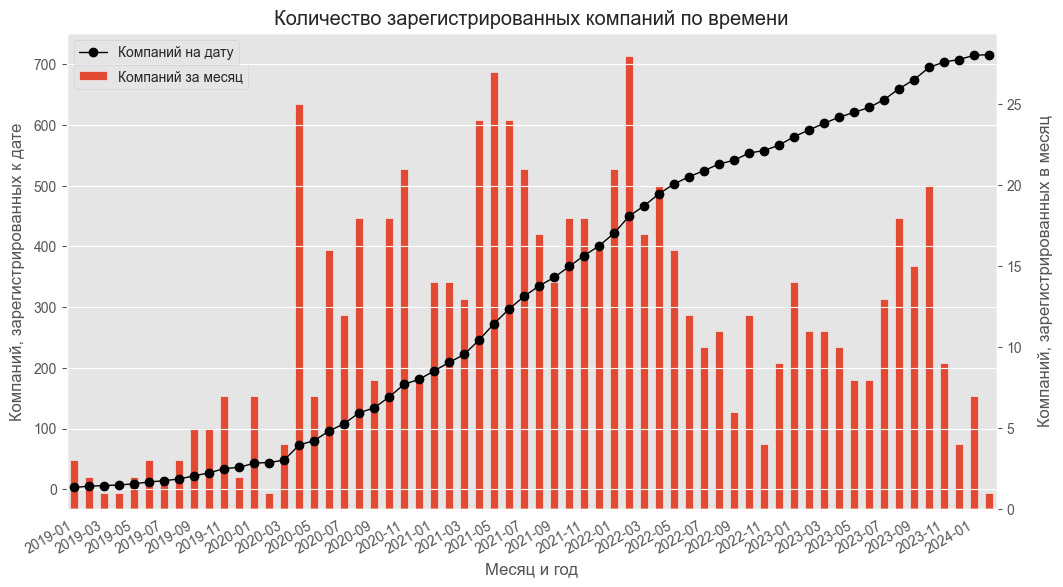

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))

companies_dimanic[['companys_per_month']].plot(kind='bar', 
                               stacked=False, 
                               title='Количество зарегистрированных компаний по времени', 
                               ax=ax, 
                               grid=False)

ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), 
         companies_dimanic[['companies_cumsum']].values,  
         linestyle='-', 
         marker='o', 
         color='k', 
         linewidth=1.0, 
         label='Компаний на дату')

ax.set_xticklabels(companies_dimanic.index, fontsize=10)
ax.set_xlabel('Месяц и год')

ax.yaxis.set_ticks_position('right')
ax.set_ylabel('Компаний, зарегистрированных к дате', labelpad=30)


ax2.yaxis.set_ticks_position("left")
ax2.set_ylabel('Компаний, зарегистрированных в месяц', labelpad=30)

ax.legend(['Компаний за месяц'], loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1))

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
fig.autofmt_xdate()
plt.show();

Мы видим, что большой, но нестабильный прирост компаний начался с мая 2020 года, а от 200 компаний в месяц начало регистрироваться с февраля 2021 года по сентябрь 2022 года.  
По графику можем предположить, что есть сезонность, рост регистраций компаний идет до лета, а минимум регистраций приходится на зиму.  Что логично, т.к. зимой, обычно, не начинают строить новые объекты, а делают только внетренние отделочные работы.

Посмотрим, компании с каким количество сотрудников больше всего зарегистрировано.

employer_count_interval
6      2
7      3
8      4
5      9
4     14
3     46
2    146
1    492
Name: count, dtype: int64



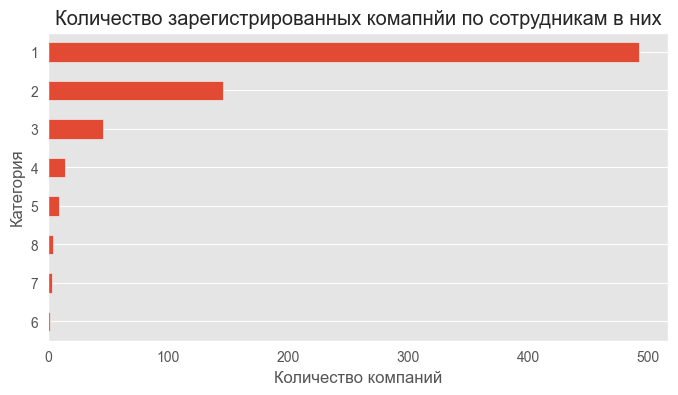

In [53]:
companies['employer_count_interval'].value_counts().sort_values().plot.barh(figsize=(8, 4))
plt.grid(axis='x')
plt.title('Количество зарегистрированных компаний по сотрудникам в них')
plt.xlabel('Количество компаний')
plt.ylabel('Категория');

print(companies['employer_count_interval'].value_counts().sort_values())
print()

Категории в таблице:  
- 1: 1-4 сотрудника,
- 2: 5-10 сотрудников, 
- 3: 11-20 сотрудников, 
- 4: 21-30 сотрудников, 
- 5: 31-50 сотрудников, 
- 6: 51-100 сотрудников, 
- 7: 101-200 сотрудников, 
- 8: >201 сотрудников.

Мы видим, что больше всего компаний с 1-4 сотрудниками, а меньше всего компаний с 51-100 сотрудниками.

billing_is_over
False    235
True     481
Name: count, dtype: int64



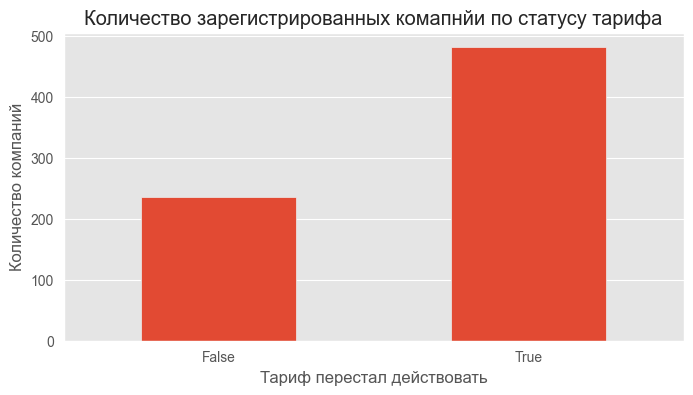

In [60]:
companies['billing_is_over'].value_counts().sort_values().plot.bar(figsize=(8, 4))
plt.grid(axis='x')
plt.title('Количество зарегистрированных комапнйи по статусу тарифа')
plt.xlabel('Тариф перестал действовать')
plt.xticks(rotation=0, ha='center')
plt.ylabel('Количество компаний');

print(companies['billing_is_over'].value_counts().sort_values())
print()

Мы видим, что у более чем половины зарегистрированных компаний тариф не действует.

Посмотрим, как распределены компании по оплате, в зависимости, платный ли у них тариф.  
Мы знаем, что бесплатные тарифы - это 1, 18 и 22.

In [63]:
free_plans =[1, 18, 22] 

In [64]:
def tariff_cat(cell_value):
    #проверяем, есть ли номериз ячейки в списке бесплатных тарифов, если да - возвращаем бесплатный тариф
    if cell_value in free_plans:
        return 'бесплатный тариф'     
    #в остальных случаях возвращаем платный тариф
    else:
        return  'платный тариф'

In [65]:
companies['tariff_cat'] = companies['billing_tariff_id'].apply(tariff_cat)
print(companies['tariff_cat'].value_counts())

tariff_cat
платный тариф    716
Name: count, dtype: int64


Мы видим, что в датафрейме companies у всех указаны платные тарифы, т.е. в эту базу не попали компании на тестовых или промо тарифах.

По комментариям заказчика, этот датафрейм не является точным при определении, оплачен ли тариф у комапнии.

Создадим список компаний и их тарифов, срок истечения еще не пришел из датафрейма **billing**.

In [101]:
actual_companies = billing.query('payed_until >= @current_date')[['company_id', 'billing_tariff_id']].copy()

In [102]:
temp = actual_companies.groupby(by='company_id', as_index=False)['billing_tariff_id'].count()
len(temp.query('billing_tariff_id > 1'))

108

In [104]:
temp = actual_companies.query('billing_tariff_id not in @free_plans').groupby(by='company_id', as_index=False)['billing_tariff_id'].count()
len(temp.query('billing_tariff_id > 1'))

108

In [111]:
temp.query('billing_tariff_id > 1')

,company_id,billing_tariff_id
0,5,2
5,512,3
10,1088,2
11,1255,3
23,2462,10
24,2771,3
26,2919,2
29,3210,2
35,3518,2
36,3600,2


In [105]:
actual_companies.head()

,company_id,billing_tariff_id
204,512,2
346,512,7
863,3752,7
1825,4603,2
1833,512,2


In [109]:
free_plans

[1, 18, 22]

In [108]:
actual_companies.query('billing_tariff_id not in @free_plans')['billing_tariff_id'].value_counts()

billing_tariff_id
2     321
7     227
9      80
10     24
17     18
20     10
13      8
19      8
3       3
6       1
21      1
4       1
Name: count, dtype: int64

In [83]:
billing['pay_check'] = billing['payed_until'].apply(tariff_cat)
current_date

In [112]:
billing.query('company_id == 4004')

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,pay_check
1826,5347,4980,4004,2,2023-12-02 00:00:00,True,2021-09-02 11:02:03,2022-11-25 13:41:51,7,NaN,2021-09-02,2023-12-02
5656,5770,4980,4004,2,2023-10-11 00:00:00,False,2021-10-11 12:14:13,2021-10-11 12:14:18,35,NaN,NaT,2023-10-11
5657,5771,4980,4004,2,2023-10-11 00:00:00,False,2021-10-11 12:21:44,2021-10-11 12:21:48,35,NaN,NaT,2023-10-11
6269,6375,4980,4004,2,2023-12-01 00:00:00,False,2021-12-01 16:23:08,2021-12-01 16:23:34,35,NaN,NaT,2023-12-01
6704,6783,4980,4004,7,2023-07-13 00:00:00,False,2022-01-13 14:39:03,2022-01-13 14:39:10,26,NaN,NaT,2023-07-13
7436,9178,4980,4004,9,2023-08-19 00:00:00,False,2022-08-19 09:22:30,2022-08-19 09:22:34,29,NaN,NaT,2023-08-19
8060,9150,4980,4004,2,2024-08-17 00:00:00,False,2022-08-17 11:24:51,2022-08-17 11:24:55,35,NaN,NaT,2024-08-17
8529,9046,4980,4004,2,2024-02-03 00:00:00,False,2022-08-03 10:29:35,2022-08-03 10:29:40,24,NaN,NaT,2024-02-03
8917,8897,4980,4004,9,2024-01-14 00:00:00,False,2022-07-14 14:58:19,2022-07-14 14:58:25,30,NaN,NaT,2024-01-14
9220,9392,4980,4004,2,2023-09-26 00:00:00,False,2022-09-26 09:59:38,2022-09-26 09:59:42,8,NaN,NaT,2023-09-26


In [84]:
billing['pay_check'].value_counts()

pay_check
платный тариф    3480
Name: count, dtype: int64

In [85]:
billing.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date,pay_check
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT,платный тариф
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21,платный тариф
16,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6,NaN,NaT,платный тариф
18,3065,2352,2035,7,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23,NaN,NaT,платный тариф
24,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9,NaN,2020-12-29 00:00:00,платный тариф


In [40]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 19 to 17972
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       716 non-null    int64         
 1   working_direction        716 non-null    object        
 2   employer_count_interval  716 non-null    int64         
 3   created_at               716 non-null    datetime64[ns]
 4   updated_at               716 non-null    datetime64[ns]
 5   billing_tariff_id        716 non-null    int64         
 6   billing_is_over          716 non-null    bool          
 7   working_cat              716 non-null    object        
 8   created_year_month       716 non-null    object        
dtypes: bool(1), datetime64[ns](2), int64(3), object(3)
memory usage: 51.0+ KB


In [69]:
billing.head()

,id,user_id,company_id,billing_tariff_id,payed_until,is_payed,created_at,updated_at,billing_tariff_price_id,comment,pay_date
4,3050,567,512,3,2021-12-22 06:08:22,False,2020-12-22 06:08:22,2020-12-22 06:08:22,12,NaN,NaT
6,3051,2861,2474,7,2021-12-22 00:00:00,True,2020-12-22 08:36:02,2020-12-22 08:36:21,23,NaN,2020-12-22 08:36:21
16,3059,1902,1645,2,2021-03-24 09:18:04,False,2020-12-24 09:18:04,2020-12-24 09:18:04,6,NaN,NaT
18,3065,2352,2035,7,2022-01-29 23:59:59,False,2020-12-25 07:59:35,2020-12-25 07:59:35,23,NaN,NaT
24,3062,1074,926,3,2021-01-30 00:00:00,True,2020-12-24 12:47:52,2020-12-25 12:34:34,9,NaN,2020-12-29 00:00:00


In [42]:
# activities, billing, companies, people